<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Salary_Prediction_text_classification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Job Salary Prediction (NLP - text classification)


https://www.kaggle.com/competitions/job-salary-prediction

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F


from collections import Counter
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.auto import tqdm

In [2]:
%matplotlib inline

In [3]:
%%capture
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip

data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)

In [4]:
data.shape

(244768, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [6]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


### Drop unnecessary data

In [7]:
df = data.drop(['Id', 'LocationRaw', 'SalaryRaw', 'SourceName', 'SalaryNormalized'], axis=1)
df = df.rename(columns={'LocationNormalized':'Location'})

### Create target column with log of salary to mtigate a huge salary gap which is a result of social inequality. That would help is we want to minimize MSE.

In [8]:
df['SalaryLog'] = np.log1p(data['SalaryNormalized']).astype('float32')

In [9]:
df.nunique()

Title              135435
FullDescription    242138
Location             2732
ContractType            2
ContractTime            2
Company             20812
Category               29
SalaryLog            8454
dtype: int64

### Fill empty values

(better do that before converting object to category)

<Axes: >

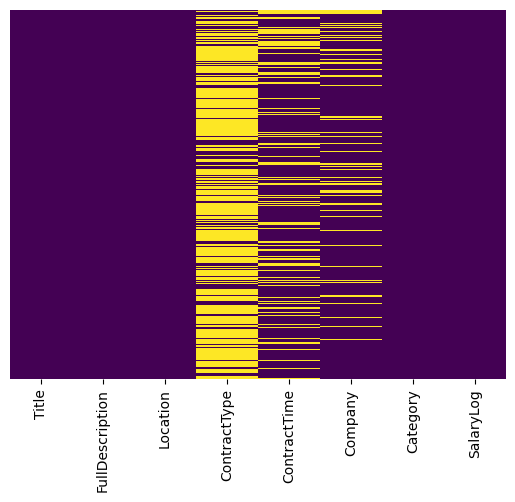

In [10]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=False)

In [11]:
for col in ['ContractType', 'ContractTime', 'Company', 'Title']:
  print(f"{round(df[col].isna().sum() / df[col].shape[0] *100, 4)}% of {col} are NaNs")

73.2637% of ContractType are NaNs
26.1084% of ContractTime are NaNs
13.2493% of Company are NaNs
0.0004% of Title are NaNs


In [12]:
df[df['Title'].isna()]

,Title,FullDescription,Location,ContractType,ContractTime,Company,Category,SalaryLog
1588,NaN,Quality Improvement Manager North West England...,Liverpool,full_time,NaN,NaN,Healthcare & Nursing Jobs,10.657283


Since we have only one empty value in Title and we know exactly what it is we can fill it in the following way

In [13]:
#Since we have only one missing title
df['Title'] = df['Title'].fillna('quality improvement manager')

Looks like we don't need ContractType but we might be able to fill the values after text classification

In [14]:
df = df.drop(['ContractType'], axis=1)

Same goes for Contract time. Since it's got less than 50% of empty values we leave it in the dataset, but replace NaNs with 'unknown' value

In [15]:
df['ContractTime'] = df['ContractTime'].fillna('UNK')

But we don't touch ['Company'] since it will be addressed later to filter top 1000 companies and fill everything else as 'Other'

<Axes: >

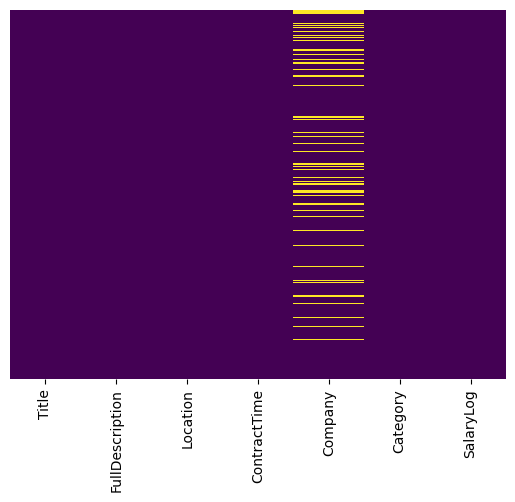

In [16]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=False)

### Group columns by purpose

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Title            244768 non-null  object 
 1   FullDescription  244768 non-null  object 
 2   Location         244768 non-null  object 
 3   ContractTime     244768 non-null  object 
 4   Company          212338 non-null  object 
 5   Category         244768 non-null  object 
 6   SalaryLog        244768 non-null  float32
dtypes: float32(1), object(6)
memory usage: 12.1+ MB


In [18]:
TARGET = 'SalaryLog'
TEXT_COLS = ['Title', 'FullDescription']
CATEGORIES = ['FullDescription', 'Location', 'ContractTime', 'Company', 'Category']

## Create tokenizer and tokenize features

In [19]:
WPT = nltk.tokenize.WordPunctTokenizer()

In [20]:
tok_df = df.copy()
for col in TEXT_COLS:
  tok_df[col] = tok_df[col].apply(lambda x: ' '.join(WPT.tokenize(x.lower().replace('_', ''))))

We're also removing all '_' from the strings since their usage just creates more entities.

Could also filter any symbols like ;'#$%^&*!~` using regex or just ord(letter)

### Bathe in tests

In [21]:
print("Tokenized:")
print(tok_df["FullDescription"][2::100000])
assert tok_df["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert tok_df["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


## Create an approved list of known word

In [22]:
token_nums = Counter()

for col in TEXT_COLS:
  for row in tok_df[col]:
    token = row.split()
    token_nums.update(token)

### Bathe in tests

In [23]:
print("Total unique tokens :", len(token_nums))
print('\n'.join(map(str, token_nums.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_nums.most_common()[-3:])))

assert token_nums.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_nums) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202494
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


#### Word frequency histogram

Text(0.5, 0, 'Word counts')

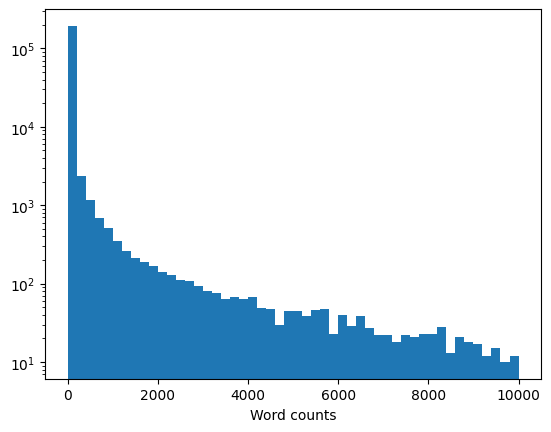

In [24]:
plt.hist(list(token_nums.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")

#### We clearly don't need words that occur once or twice in the whole text corpus. Since we don't need those words that spike at the right skew let's filter them.

## Create a list of "approved" tokens as well as "padding" token for short sentences and "unknown" token for words we cut out/haven't encountered in the trainset

In [25]:
UNK, PAD = "UNK", "PAD"
min_count = 10
tokens = [UNK, PAD] + sorted(t for t, c in token_nums.items() if c >= min_count)

### Bathe in tests

In [26]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34149
Correct!


## Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [27]:
inv_tok_idx = {token:idx for idx, token in enumerate(tokens)}

### Bathe in tests

In [28]:
assert isinstance(inv_tok_idx, dict)
assert len(inv_tok_idx) == len(tokens)
for tok in tokens:
    assert tokens[inv_tok_idx[tok]] == tok

print("Correct!")

Correct!


### Map text lines into matrices

In [29]:
UNK_IX, PAD_IX = map(inv_tok_idx.get, [UNK, PAD])

In [30]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [inv_tok_idx.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [31]:
print("Lines:")
print('\n'.join(tok_df["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(tok_df["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10798 30152  2157     1     1]
 [15012  2835     1     1     1]
 [27636 10192    16 15207 10795]]


### Create category using DictVectorizer and filter top1k most-frequent companies

In [32]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(tok_df['Company']).most_common(1001))

#### Attention: NaN in frequent companies

In [33]:
top5 = {top_companies[x]: top_counts[x] for x in range(5)}
top5

{nan: 32430,
 'UKStaffsearch': 4997,
 'CVbrowser': 2977,
 'London4Jobs': 2345,
 'Hays': 1784}

In [34]:
recognized_companies = set(top_companies)


### Update the Company column with recognized companies or "Other"

In [35]:
def filter_companies(df, frequent_companies = recognized_companies):
  df = df.copy()
  df['Company'] = df['Company'].apply(lambda company: company if company in frequent_companies else 'Other')
  df['Company'] = df['Company'].fillna('Other')
  return df

In [36]:
fltr_df = filter_companies(tok_df)

In [37]:
fltr_df['Company'].unique()

array(['Gregory Martin International', 'Other', 'Code Blue Recruitment',
       ..., 'G2 Legal LTD', 'Hays Education', 'HCL Permanent.'],
      dtype=object)

<Axes: >

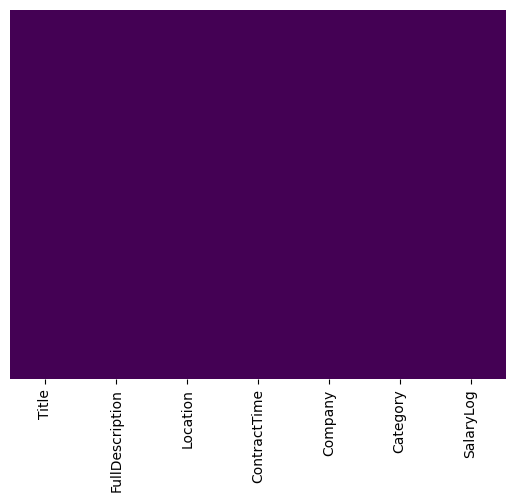

In [38]:
sns.heatmap(fltr_df.isna(), cmap='viridis', yticklabels=False, cbar=False)

And this is how we replace NaNs with 'Other' and add companies outside of top1000 to 'Other'

### Train DictVectorizer as encoder

In [39]:
dv_df = fltr_df.copy()
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(dv_df[CATEGORIES].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### Use TF-IDF instead of DictVectorizer

In [40]:
df_tfidf = fltr_df.copy()
tfidf_vectorizer = TfidfVectorizer(dtype=np.float32, token_pattern=r'\b\w+\b')
tfidf_vectorizer.fit_transform(df_tfidf['Company'])

<244768x969 sparse matrix of type '<class 'numpy.float32'>'
	with 391655 stored elements in Compressed Sparse Row format>

### Convert data types for faster df operations

In [41]:
converted_df = fltr_df.copy()
for column in converted_df.columns:
  if converted_df[column].dtype == 'object':
    converted_df[column] = converted_df[column].astype('category')

Somehow converting string 'object' types to 'category' breaks the code creating issues with assigning new values (since category values should be predefined) and using .apply() so for now we're not gonna use it and are going to convert objeto to category right before feeding the dataset to the model.

#### Check for nans once again (took me half an hour to figure out NaNs weren't fillna'd in ["Company"])

In [42]:
converted_df.isna().any()

Title              False
FullDescription    False
Location           False
ContractTime       False
Company            False
Category           False
SalaryLog          False
dtype: bool

# Creating a model

## Create a train and a validation datasets

In [43]:
data_train, data_val = train_test_split(converted_df, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", data_train.shape)
print("Validation size = ", data_val.shape)

Train size =  (195814, 7)
Validation size =  (48954, 7)


## Create batches

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [45]:
def to_tensor(batch, device):
  batch_tensors = {}
  for key, array in batch.items():
    if key in ['FullDescription', 'Title']:
      batch_tensors[key] = torch.tensor(array, device=device, dtype=torch.int64)
    else:
      batch_tensors[key] = torch.tensor(array, device=device)
  return batch_tensors


def drop_words(matrix, keep_prop, replace_with=UNK, pad_with = PAD):
  #dropout cetrain word (actually replace with UNK)
  dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
  dropout_mask &= matrix != pad_with
  return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])


def make_batch(data, maxlen = None, word_dropout=0, device=device):
  batch = {}
  batch['Title'] = as_matrix(data['Title'].values, maxlen)
  batch['FullDescription'] = as_matrix(data['FullDescription'].values, maxlen)
  batch['Categorical'] = categorical_vectorizer.transform(data[CATEGORIES].apply(dict, axis=1))

  if word_dropout:
    batch['FullDescription'] = drop_words(batch['FullDescription'], 1. - word_dropout)
  if TARGET in data.columns:
    batch[TARGET] = data[TARGET].values
  return to_tensor(batch, device)

Getting a looong one-hot for every cat feature value as tensors in Categorical column

In [46]:
new_batch = make_batch(data_train[:3], maxlen=10)

### Vectorize the columns using embedding and embeddingbag

In [47]:
linear = nn.Linear(32, 1)

#### embedding

In [49]:
embs = torch.nn.Embedding(len(tokens), 32)
print(embs(new_batch['Title']).shape)

torch.Size([3, 7, 32])


In [50]:
vectors = embs(new_batch['Title']).mean(dim=1)

embedding bag

In [51]:
embb = torch.nn.EmbeddingBag(len(tokens), 32)
embb_vectors = embb(new_batch['Title'])

In [52]:
print(linear(vectors))
print(linear(embb_vectors))

tensor([[ 0.0544],
        [ 0.1125],
        [-0.0075]], grad_fn=<AddmmBackward0>)
tensor([[0.0849],
        [0.2195],
        [0.3443]], grad_fn=<AddmmBackward0>)


## Model architecture

In [159]:
url ='https://camo.githubusercontent.com/4acbd3e2fee33a42de561019edd9fd15932993c6201e34f1908d5e18d8cf60ca/68747470733a2f2f6769746875622e636f6d2f79616e646578646174617363686f6f6c2f6e6c705f636f757273652f7261772f6d61737465722f7265736f75726365732f77325f636f6e765f617263682e706e67'
display(Image(url=url))

## Model class

In [47]:
class SalaryModel(nn.Module):
  def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), emb_size=32, conv_out_channels=16, hid_size=64):
    super(SalaryModel, self).__init__()
    #encode title
    self.title_emb = nn.Embedding(n_tokens, emb_size)
    self.title_conv1 = nn.Conv1d(emb_size, hid_size, kernel_size=3, padding=1)
    self.title_pool = nn.AdaptiveMaxPool1d(1)

    self.desc_emb = nn.Embedding(n_tokens, emb_size)
    self.desc_conv1 = nn.Conv1d(emb_size, hid_size, kernel_size=3, padding=1)
    self.desc_pool = nn.AdaptiveMaxPool1d(1)

    self.cats_fc = nn.Linear(n_cat_features, hid_size)

    self.fc = nn.Linear(3*hid_size, 1)

    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, (nn.Conv1d, nn.Embedding, nn.EmbeddingBag, nn.Linear)):
      nn.init.xavier_uniform_(module.weight)
      if module in (nn.Conv1d, nn.Linear) and not (module.bias is None):
        nn.init.zeros_(module.bias)


  def forward(self, batch):
    title = batch['Title']
    desc = batch['FullDescription']
    cats = batch['Categorical']

    ttl_emb = self.title_emb(title)
    ttl_conv = F.relu(self.title_conv1(ttl_emb.transpose(1,2)))
    ttl_pool = self.title_pool(ttl_conv).squeeze(-1)

    dsc_emb = self.desc_emb(desc)
    dsc_conv = F.relu(self.desc_conv1(dsc_emb.transpose(1,2)))
    dsc_pool = self.desc_pool(dsc_conv).squeeze(-1)

    linear_cats = F.relu(self.cats_fc(cats))

    #since we're using _global_ pooling and reduced 1 dimension using .squeeze we don't need to flatten
    concats = torch.cat((ttl_pool, dsc_pool, linear_cats), dim=1)
    outputs = self.fc(concats)
    return outputs.squeeze(-1)


  def backward(self, loss):
    loss.backward()

#### Run baseline

In [48]:
device

'cuda'

In [49]:
sm = SalaryModel()
sm.to(device)
sm_pred = sm.forward(new_batch)
sm_pred

tensor([0.0662, 0.0599, 0.0588], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [51]:
model = SalaryModel()
model.to(device)

batch = make_batch(data_train[:100])

criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch['SalaryLog'])
dummy_loss


tensor(103.8069, device='cuda:0', grad_fn=<MseLossBackward0>)

#### Bathe in tests

In [52]:
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

# Create a class to train and eval model

In [100]:
class ModelTrainer:
  def __init__(self, model, optimizer=False, loss=False, batch_size=16, lr = False, epochs=5, device=device):
    self.device = device
    self.epochs = epochs
    self.batch_size = batch_size
    self.lr = lr or 4e-4
    self.model = model
    self.model.to(self.device)

    self.optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=self.lr)
    self.criterion = loss or nn.MSELoss(reduction='sum')


  def print_metrics(self, data, device=device, **kwargs):
    sq_err = abs_err = num_samples = 0.0
    self.model.eval()

    with torch.no_grad():
      for batch in self.iter_minibatches(data, **kwargs):
        b_pred = self.model(batch)
        sq_err += torch.sum(torch.square(b_pred-batch[TARGET]))
        abs_err += torch.sum(torch.abs(b_pred-batch[TARGET]))
        num_samples += len(b_pred)

    mse = sq_err.detach().cpu().numpy() / num_samples
    mae = abs_err.detach().cpu().numpy() / num_samples

    print(f'Results:\n_____MSE:{round(mse, 5)}\n______MAE:{round(mae, 5)}\n')
    return mse, mae


  def iter_minibatches(self, data, shuffle=True, cycle=False, **kwargs):
    while True:
      idx = np.arange(len(data))
      if shuffle:
        idx = np.random.permutation(idx)

      for start in range(0, len(idx), self.batch_size):
        batchrange = data.iloc[idx[start:start+self.batch_size]]
        batch = make_batch(batchrange, device=self.device, **kwargs)
        yield batch

      if not cycle:
        break


  def train_model(self, data_train, data_val):
    for epoch in range(self.epochs):
      running_loss = 0.0
      model.train()
      for i, batch in tqdm(enumerate(
          self.iter_minibatches(data_train)), total=len(data_train) // self.batch_size
      ):
        y_pred = model(batch)
        loss = self.criterion(y_pred, batch[TARGET])
        self.optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        self.optimizer.step()
      Print('EPOCH:', epoch)
      mse, mae = self.print_metrics(data_val)

In [97]:
another_model = SalaryModel()
trainer = ModelTrainer(another_model)

In [98]:
trainer.train_model(data_train[:2000], data_val[:2000])

  0%|          | 0/125 [00:00<?, ?it/s]

Results:
_____MSE:105.1582
______MAE:10.24317



  0%|          | 0/125 [00:00<?, ?it/s]

Results:
_____MSE:105.15827
______MAE:10.24317



  0%|          | 0/125 [00:00<?, ?it/s]

Results:
_____MSE:105.1585
______MAE:10.24318



  0%|          | 0/125 [00:00<?, ?it/s]

Results:
_____MSE:105.15791
______MAE:10.24316



  0%|          | 0/125 [00:00<?, ?it/s]

Results:
_____MSE:105.15845
______MAE:10.24318

